# In thid notebook, I try to increase the accuracy of the Convolutional Nerural Network(CNN) model.
Reference the [TensorflowTutorial](https://www.tensorflow.org/tutorials/audio/simple_audio).

In [1]:
#Check if colab is connect to gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
# Check if colab is using high-RAm runtime
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
pip install tensorflow_io

In [4]:
pip install pydub

In [5]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wavfile
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import models

# set random seed for reproducibility
seed = 920
tf.random.set_seed(seed)
np.random.seed(seed)


# Load Data

Load data - cell takes 20 minutes to run

In [6]:
# Read in data from TensorFlow Dataset
train, test, val = tfds.load( "speech_commands", 
                             split=["train", 'test', 'validation'],
                             shuffle_files = True,
                             as_supervised = True)
assert isinstance(train, tf.data.Dataset)
assert isinstance(test, tf.data.Dataset)
assert isinstance(val, tf.data.Dataset)

print info about the classes, label names

In [7]:
builder = tfds.builder('speech_commands')
info = builder.info
commands = info.features['label'].names
print(info.features['label'].num_classes)
print(f'Commands {commands}')

12
Commands ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


# Modeling

Prepare the dataset for CNN modeling

In [8]:
AUTOTUNE = tf.data.AUTOTUNE


In [9]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [10]:
def make_spectrogram_ds(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == range(12))
  return spectrogram, label_id

In [11]:
spectrogram_ds = train.map(map_func = make_spectrogram_ds,
                           num_parallel_calls = AUTOTUNE)



In [12]:
train_ds = spectrogram_ds
val_ds = val.map(map_func = make_spectrogram_ds, num_parallel_calls = AUTOTUNE)
test_ds = test.map(map_func = make_spectrogram_ds, num_parallel_calls = AUTOTUNE)

Batch training and validation sets for model training

In [13]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add .cache to reduce read latency

In [14]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [15]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0         
 )                           

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train model over 10 epochs

In [17]:
# Cell takes 1 hour to run
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
1337/1337 [==============================] - 157s 117ms/step - loss: 0.9339 - accuracy: 0.7125 - val_loss: 0.5048 - val_accuracy: 0.8373
Epoch 2/10
1337/1337 [==============================] - 105s 79ms/step - loss: 0.5630 - accuracy: 0.8185 - val_loss: 0.3913 - val_accuracy: 0.8766
Epoch 3/10
1337/1337 [==============================] - 104s 78ms/step - loss: 0.4376 - accuracy: 0.8590 - val_loss: 0.3639 - val_accuracy: 0.8885
Epoch 4/10
1337/1337 [==============================] - 104s 78ms/step - loss: 0.3706 - accuracy: 0.8799 - val_loss: 0.3005 - val_accuracy: 0.9080
Epoch 5/10
1337/1337 [==============================] - 104s 78ms/step - loss: 0.3220 - accuracy: 0.8948 - val_loss: 0.3056 - val_accuracy: 0.9119
Epoch 6/10
1337/1337 [==============================] - 104s 78ms/step - loss: 0.2894 - accuracy: 0.9045 - val_loss: 0.2969 - val_accuracy: 0.9196
Epoch 7/10
1337/1337 [==============================] - 105s 78ms/step - loss: 0.2621 - accuracy: 0.9136 - val_loss: 

Save Model

# Metrics


Print out metrics

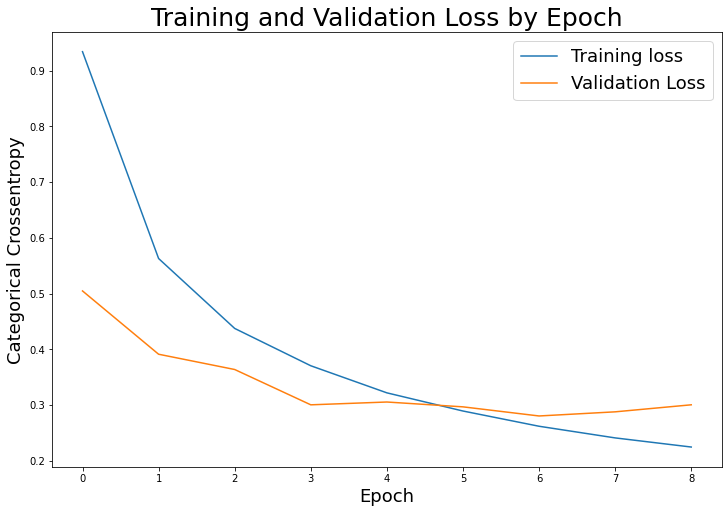

In [18]:

metrics = history.history
plt.figure(figsize = (12,8))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['Training loss', 'Validation Loss'], fontsize = 18)

# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
#plt.xticks(epoch_labels, epoch_labels)

fig1 = plt.gcf()
plt.show()
fig1.savefig('./drive/MyDrive/audio_commands/visuals/loss.png');

Run the model on the test set and check performance

In [19]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [20]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


Display conufusion matrix

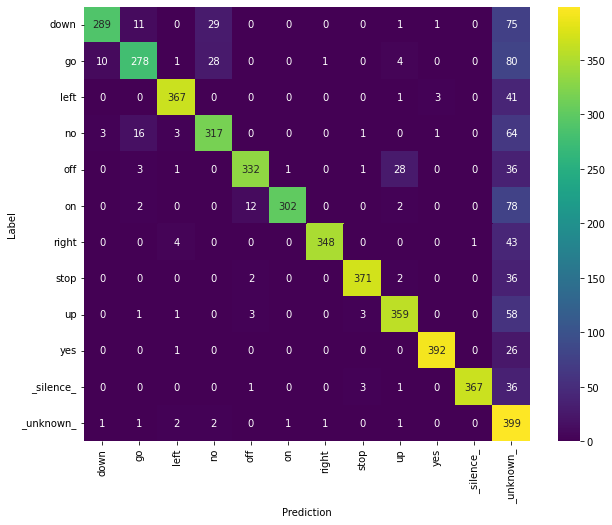

In [21]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap = 'viridis')
plt.xlabel('Prediction')
plt.ylabel('Label')
fig1 = plt.gcf()
plt.show()
fig1.savefig('./drive/MyDrive/audio_commands/visuals/confusion_matrix.png');

In [22]:
model.save('./drive/MyDrive/audio_commands/saved_model/cnn_model_2')

INFO:tensorflow:Assets written to: ./drive/MyDrive/audio_commands/saved_model/cnn_model_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/audio_commands/saved_model/cnn_model_2/assets


Create sample predictions for each model

In [23]:
prediction = []

for spectrogram, label in spectrogram_ds.batch(1):
  for index in range(11):
    if index == label:
        temp_pred  = model(spectrogram)
        prediction.append({'prediction': temp_pred[0], 'commands': commands[label[0]]})


Find the location of a sample command

In [35]:
preds_location = []

count = 0
for command in commands:
  for row in range(len(prediction)):
      if count == 0:
        if prediction[row]['commands'] == command:
          preds_location.append(row)
          count += 1
  count = 0



In [36]:
len(preds_location)

11

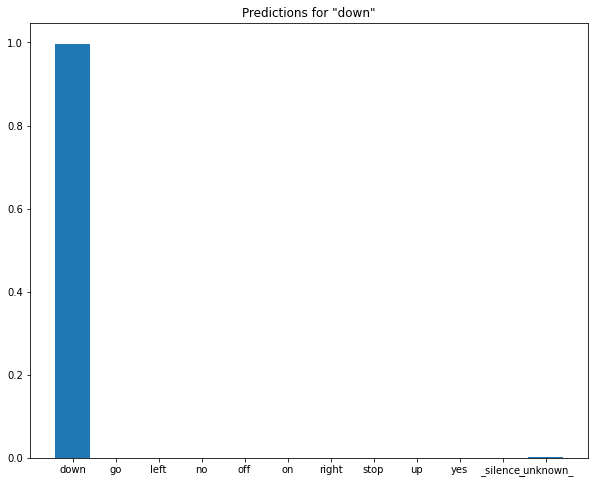

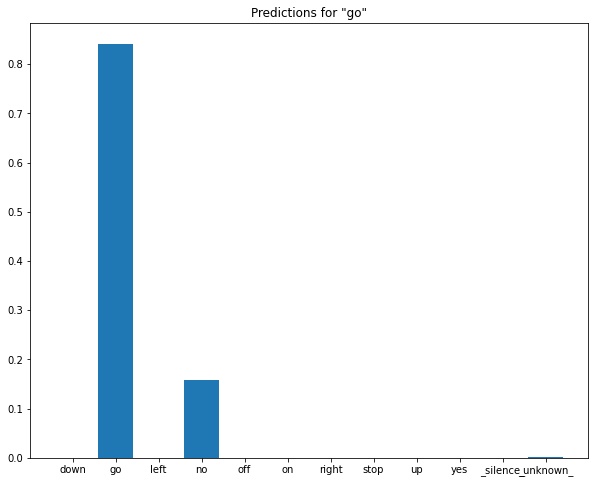

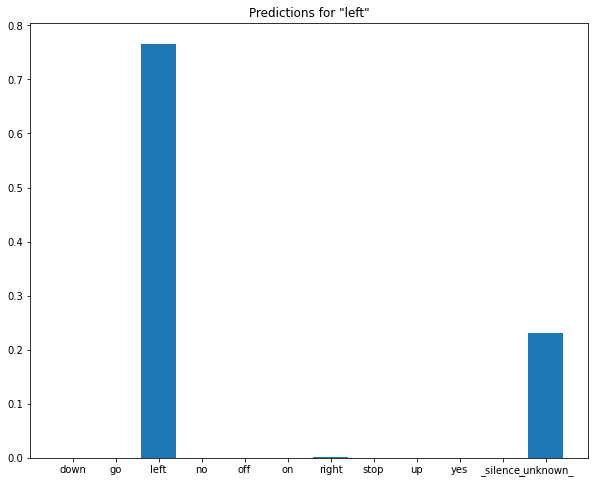

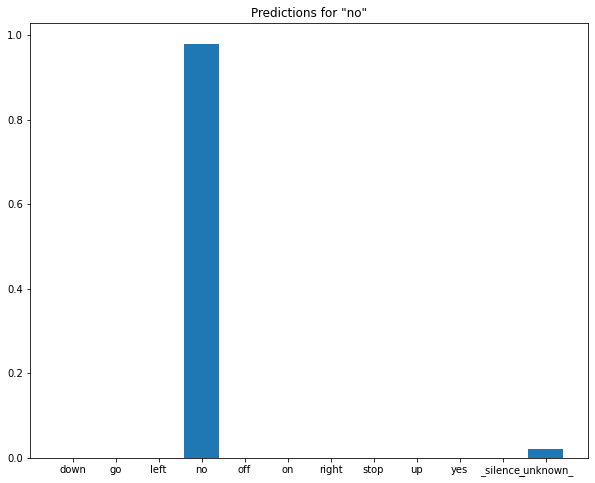

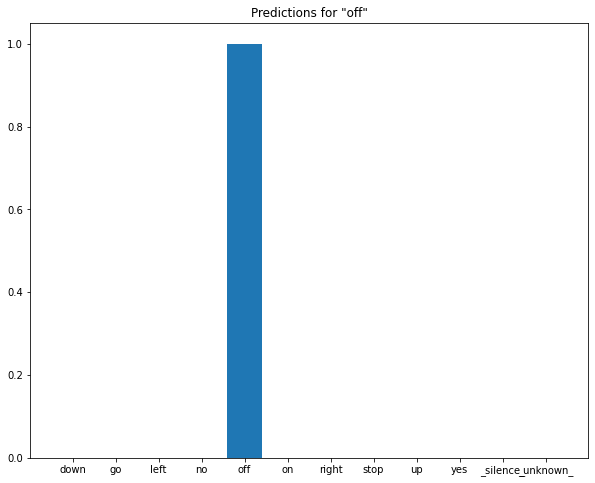

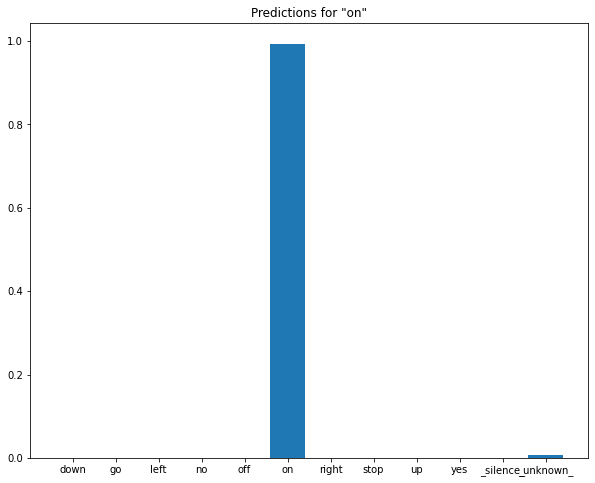

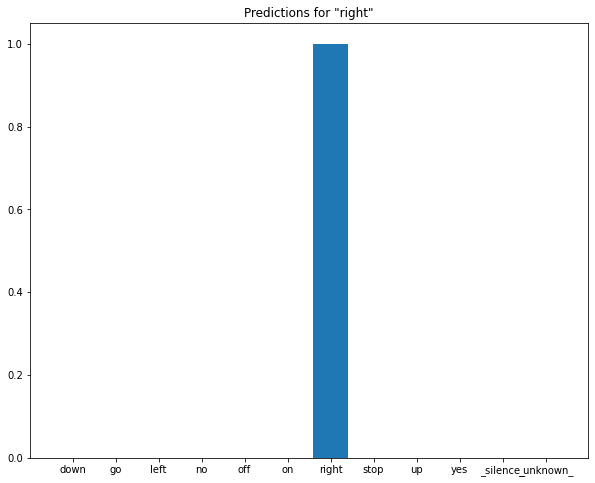

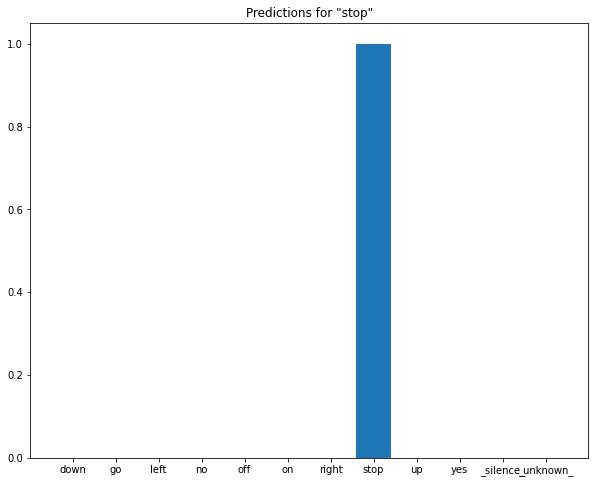

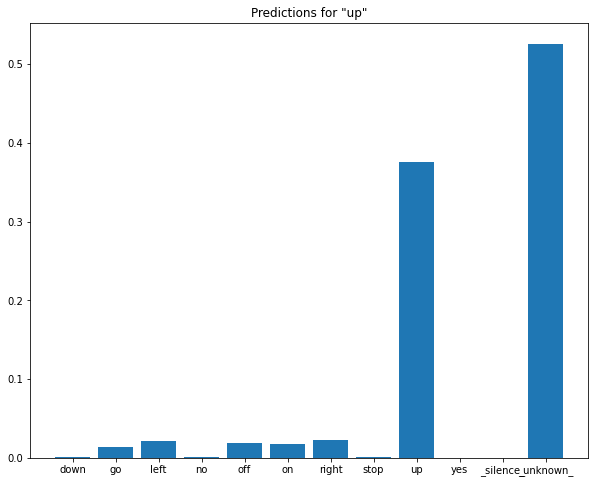

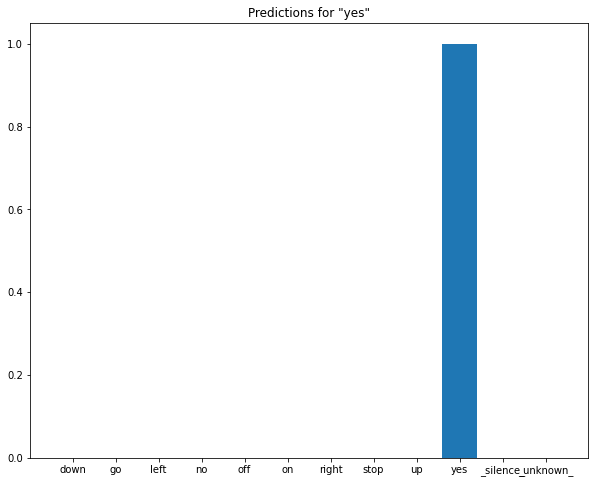

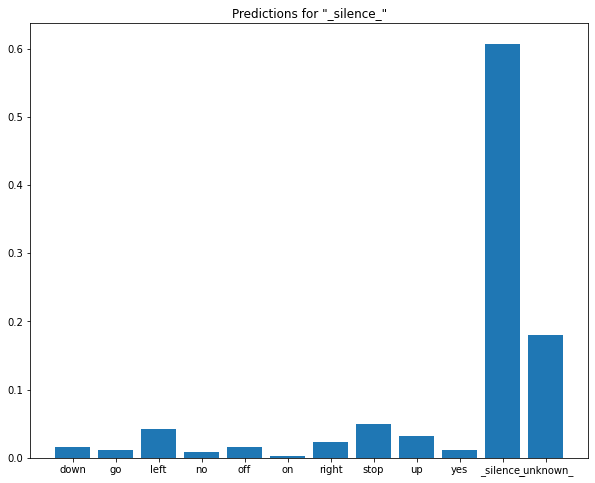

In [37]:

for row in preds_location:
  key = prediction[row]['commands']
  filename = './drive/MyDrive/audio_commands/visuals/preds_' + key + '.png'

  plt.figure(figsize = (10,8))
  plt.bar(commands, tf.nn.softmax(prediction[row]['prediction']))
  plt.title(f'Predictions for "{key}"')
  fig1 = plt.gcf()
  plt.show()
  fig1.savefig(filename);

Create a plot with all sample predictions

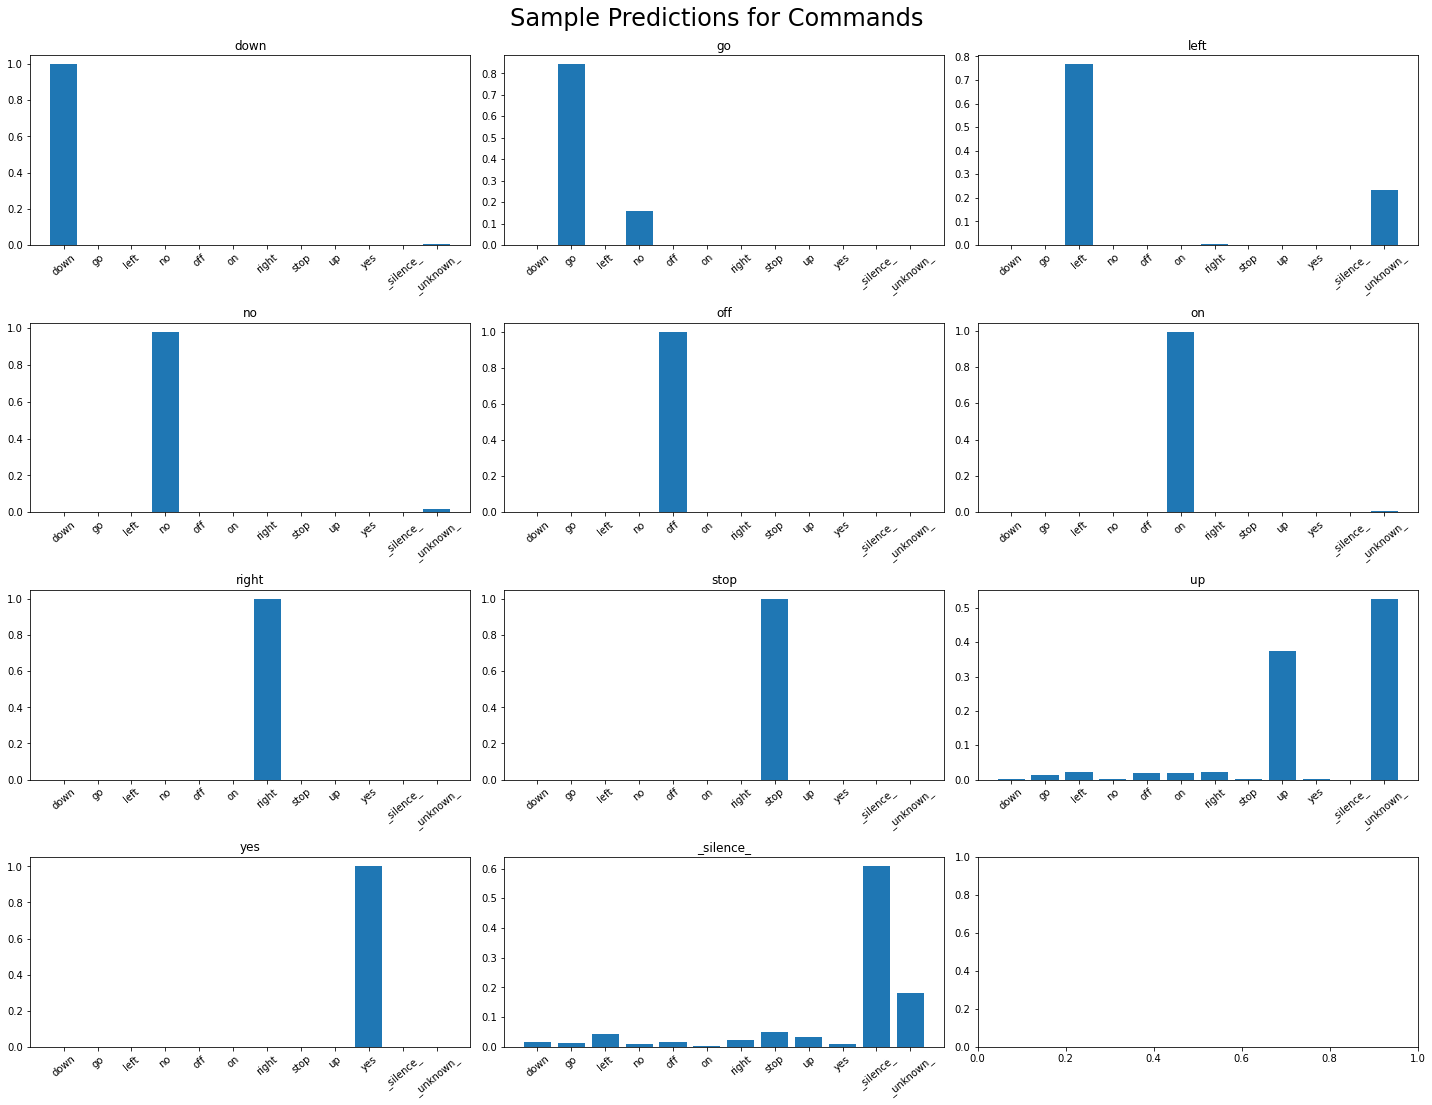

In [39]:
rows = 4
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(20,15))

for i, preds in enumerate(preds_location):
  key = prediction[preds]['commands']
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.bar(commands, tf.nn.softmax(prediction[preds]['prediction']))
  ax.set_title(label = key)
  for label in ax.get_xticklabels():
      label.set_rotation(40)
  #ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  #label = label.numpy()
  #ax.set_title(label)
fig.tight_layout()
plt.suptitle('Sample Predictions for Commands', fontsize = 24, va = 'top', x = 0.5, y = 1.02)
fig1 = plt.gcf()
plt.show()
fig1.savefig('./drive/MyDrive/audio_commands/visuals/all_preds.png');